In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as sma

%matplotlib inline
#plt.style.available

C:\Users\ed\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Reading in index data

index_df = pd.read_excel(r'E:\EME Data\Index Data FTSE S&P.xlsx', date_parser= True, names=['Date', 'FTSE100', 'S&P500'])
index_df.head()

,Date,FTSE100,S&P500
0,1984-01-02,1000.0,164.93
1,1984-01-03,997.5,164.04
2,1984-01-04,998.6,166.78
3,1984-01-05,1015.8,168.81
4,1984-01-06,1029.0,169.28


fivethirtyeight


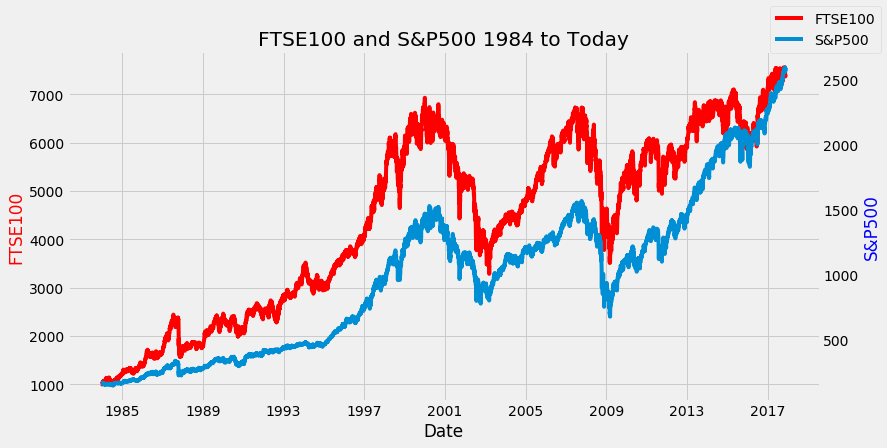

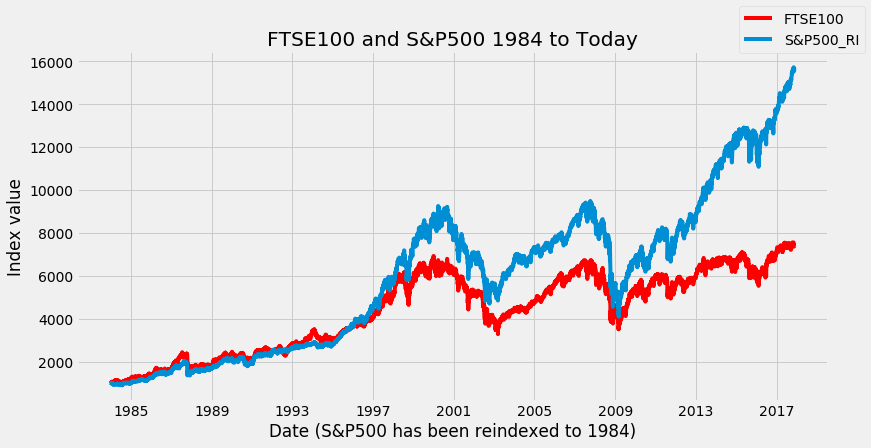

In [5]:
#Plotting index data

style = plt.style.available[4]
plt.style.use(style)
print(style)

# Re-Indexing S&P500 to start with an initial value of 1000
initial_index_value_SP = index_df.iloc[0,2]
index_df['S&P500_RI'] = round(1000*(index_df['S&P500']/initial_index_value_SP),1)
index_df.head()
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(index_df.Date, index_df.FTSE100, color= 'r')
axes2 = axes.twinx()
axes2.plot(index_df.Date, index_df['S&P500'])
axes2.grid(False)
axes.set_title('FTSE100 and S&P500 1984 to Today')
axes.set_xlabel('Date')
axes.set_ylabel('FTSE100', color = 'r')

axes2.set_ylabel('S&P500', color = 'b')
fig.legend()

plt.show()

fig, axes = plt.subplots(figsize = (12,6))
axes.plot(index_df.Date, index_df.FTSE100, color= 'r')

axes.plot(index_df.Date, index_df['S&P500_RI'])

axes.set_title('FTSE100 and S&P500 1984 to Today')
axes.set_xlabel('Date (S&P500 has been reindexed to 1984)')
axes.set_ylabel("Index value")

fig.legend()

plt.show()

In [6]:
#Reading in terror data and then creating a dataframe with only the UK from 1984 onwards

terror = pd.read_excel(r'E:\EME Data\Terror_Edited.xlsx')
terror_uk = terror[terror['country'] == 603].copy()
#terror_uk = terror_uk[terror_uk['iyear'] > 1983]
terror_uk.head()


,eventid,iyear,imonth,iday,country_txt,country,nkill,nwound,propvalue,YM,YM2,quarter,incident
364,197006260001,1970,6,26,United Kingdom,603,5,0,0.0,1970/6,1970-06-01,2,1
365,197006270001,1970,6,27,United Kingdom,603,3,0,0.0,1970/6,1970-06-01,2,1
366,197006270002,1970,6,27,United Kingdom,603,1,0,0.0,1970/6,1970-06-01,2,1
367,197006270003,1970,6,27,United Kingdom,603,1,0,0.0,1970/6,1970-06-01,2,1
368,197006270004,1970,6,27,United Kingdom,603,3,1,0.0,1970/6,1970-06-01,2,1


In [7]:
#Checking for missing days coded as 0
#terror_uk['iday'].value_counts(sort=False)
terror_uk[terror_uk['iyear'] == 1993]
# missing_event_list = list(terror_uk.eventid[terror_uk['iday'] == 0])

# terror_uk['imonth'].value_counts(sort=False)
# # We aren't missing any months - only 7 days

,eventid,iyear,imonth,iday,country_txt,country,nkill,nwound,propvalue,YM,YM2,quarter,incident


In [8]:
# Dropping unknown values for now
condition = (terror_uk['iday'] == 0)
missing_dates = terror_uk[condition]


#Checking for missing dates and then adjusting (dropping them for now) and checking again


print(terror_uk['iday'].value_counts(sort=False)[0])
terror_uk_elided = terror_uk[terror_uk['iday'] != 0].copy()
try:
    print(terror_uk_elided['iday'].value_counts(sort = False)[0])
except KeyError :
    print('No day zeroes')
terror_uk_elided.head()

#Adding day values to year month


terror_uk_elided['iday'] = terror_uk_elided['iday'].astype(int).astype(str)
terror_uk_elided['YMD'] = (terror_uk_elided['YM'] + '/' + terror_uk_elided['iday'])
terror_uk_elided['YMD'] = pd.to_datetime(terror_uk_elided['YMD'], format= '%Y/%m/%d')
# Terror attacks that happen on weekends won't appear in our index dataset which only includes weekdays. Therefore we need to 
# move terror attacks on Sat/Sun to Monday (i.e. the first day the stock market can receive/react to the new terror info)
from pandas.tseries.offsets import *

terror_uk_elided['Sat_indicator'] = (terror_uk_elided['YMD'].dt.weekday == 5).astype(int)
terror_uk_elided['Sun_indicator'] = (terror_uk_elided['YMD'].dt.weekday == 6).astype(int)

#Resetting the index so iloc matches with the previous index (we've lost a lot of observations from the original dataset 
# that were from other countries)
terror_uk_elided_reset = terror_uk_elided.reset_index()
#Creating a list that contains the iloc row identifier for every saturday attack in the dataset
Saturdays = list(terror_uk_elided_reset[terror_uk_elided_reset['Sat_indicator'] == 1].index)

#For every saturday in the dataset we add two days to the observed date - however we don't change iday/imonth/iyear for reference
#purposes
for event in Saturdays:
    offset_date = (terror_uk_elided.iloc[event, 13] + DateOffset(days=2))
    terror_uk_elided.iloc[event, 13] = offset_date

Sundays = list(terror_uk_elided_reset[terror_uk_elided_reset['Sun_indicator'] == 1].index)
for event in Sundays:
    offset_date = (terror_uk_elided.iloc[event, 13] + DateOffset(days=1))
    terror_uk_elided.iloc[event, 13] = offset_date


## Changing unknown property damage to 0
terror_uk_elided['propvalue'] = terror_uk_elided['propvalue'].replace(to_replace = -99, value = 0)

#Changing terror_uk_elided_reset along with terror_uk_elided to keep track of the original uk terror data
terror_uk_elided_reset['propvalue'] = terror_uk_elided_reset['propvalue'].replace(to_replace = -99, value = np.nan)





#Grouping observations by date
terror_uk_elided['attackno.'] = 1

grouped_terror = terror_uk_elided.groupby( 'YMD', as_index=False).sum()
grouped_terror['Day'] = grouped_terror['YMD'].dt.weekday_name

#terror_uk_elided_reset.to_excel(r'E:\EME Data\UK_Terror_Cleaned.xlsx')

grouped_terror.head()

27
No day zeroes


,YMD,eventid,iyear,imonth,country,nkill,nwound,propvalue,quarter,incident,Sat_indicator,Sun_indicator,attackno.,Day
0,1970-06-26,197006260001,1970,6,603,5,0,0.0,2,1,0,0,1,Friday
1,1970-06-29,788025080010,7880,24,2412,8,1,0.0,8,4,4,0,4,Monday
2,1970-08-11,197008110001,1970,8,603,2,0,0.0,3,1,0,0,1,Tuesday
3,1970-09-04,197009040003,1970,9,603,1,0,0.0,3,1,0,0,1,Friday
4,1970-09-14,197009120002,1970,9,603,0,0,0.0,3,1,1,0,1,Monday


In [9]:
#Merging

merged_df = index_df.merge(right = grouped_terror[['nkill', 'nwound', 'YMD', 'propvalue', 'attackno.']],
                           how = 'left', right_on = 'YMD', left_on='Date')
merged_df['const'] = 1
merged_df.tail()
print(merged_df['const'].shape, merged_df['FTSE100'].shape, merged_df['S&P500_RI'].shape)

merged_df['nkill'] = merged_df['nkill'].fillna(0, axis = 0)
merged_df['nwound'] = merged_df['nwound'].fillna(0, axis = 0)
merged_df['propvalue'] = merged_df['propvalue'].fillna(0, axis = 0)
merged_df['attackno.'] = merged_df['attackno.'].fillna(0, axis = 0)
merged_df = merged_df.drop('YMD', axis=1)

merged_df['logFTSE'] = np.log(merged_df['FTSE100'])
merged_df['logS&P'] = np.log(merged_df['S&P500_RI'])
merged_df['L.logFTSE'] = merged_df['logFTSE'].shift(1)
merged_df['L.logS&P'] = merged_df['logS&P'].shift(1)
merged_df['terrorattack'] = merged_df['attackno.']/merged_df['attackno.']
merged_df['terrorattack'] = merged_df['terrorattack'].fillna(0, axis = 0)
merged_df['terrorattack'] = merged_df['terrorattack'].astype(int)
merged_df['Day'] = merged_df['Date'].dt.weekday_name
merged_df.head(10)


(8840,) (8840,) (8840,)


,Date,FTSE100,S&P500,S&P500_RI,nkill,nwound,propvalue,attackno.,const,logFTSE,logS&P,L.logFTSE,L.logS&P,terrorattack,Day
0,1984-01-02,1000.0,164.93,1000.0,2.0,0.0,1830000.0,8.0,1,6.907755,6.907755,NaN,NaN,1,Monday
1,1984-01-03,997.5,164.04,994.6,0.0,0.0,0.0,0.0,1,6.905252,6.902341,6.907755,6.907755,0,Tuesday
2,1984-01-04,998.6,166.78,1011.2,0.0,0.0,0.0,0.0,1,6.906354,6.918893,6.905252,6.902341,0,Wednesday
3,1984-01-05,1015.8,168.81,1023.5,0.0,1.0,150000.0,2.0,1,6.923432,6.930983,6.906354,6.918893,1,Thursday
4,1984-01-06,1029.0,169.28,1026.4,0.0,0.0,0.0,0.0,1,6.936343,6.933813,6.923432,6.930983,0,Friday
5,1984-01-09,1034.6,168.90,1024.1,0.0,2.0,0.0,1.0,1,6.941770,6.931569,6.936343,6.933813,1,Monday
6,1984-01-10,1034.3,167.95,1018.3,1.0,2.0,30000.0,2.0,1,6.941480,6.925890,6.941770,6.931569,1,Tuesday
7,1984-01-11,1023.4,167.79,1017.3,0.0,0.0,0.0,0.0,1,6.930886,6.924907,6.941480,6.925890,0,Wednesday
8,1984-01-12,1031.3,167.75,1017.1,0.0,0.0,0.0,0.0,1,6.938575,6.924711,6.930886,6.924907,0,Thursday
9,1984-01-13,1042.7,167.02,1012.7,0.0,0.0,0.0,0.0,1,6.949569,6.920375,6.938575,6.924711,0,Friday


Text(0.5,1,'FTSE, S&P and Terror injuries')

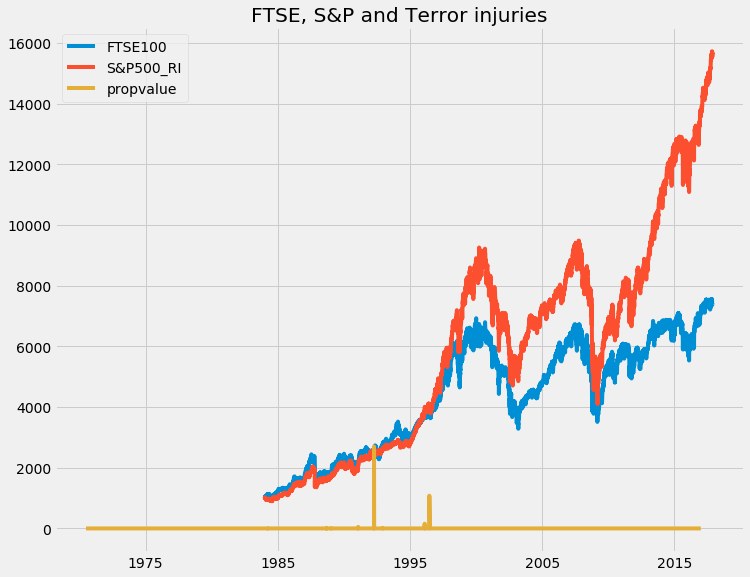

In [10]:
# Plotting Indexes vs terror injuries

# fig, axes = plt.subplots(figsize = (11,9))
# axes.plot(index_df.Date, index_df.FTSE100)
# axes.plot(index_df.Date, index_df['S&P500_RI'])
# axes.plot( terror_uk_elided['YMD'], terror_uk_elided['propvalue']*10**-6)
# axes.legend()
# axes.set_title('FTSE, S&P and Terror injuries')

In [42]:
# Just an initial OLS regression to check everything is working. As expected S&P500 has a large amount of explanatory power
reg_df = merged_df.dropna()
#reg_df = reg_df[reg_df['Date'].dt.year < 2000]
diff_SP = (reg_df['logS&P'] - reg_df['L.logS&P'])
diff_FTSE = (reg_df['logFTSE']- reg_df['L.logFTSE'])
X_matrix = np.matrix((reg_df['const'], diff_SP,  reg_df['propvalue'] )).T
print(X_matrix.shape)
reg1 = sma.regression.linear_model.OLS(endog=diff_FTSE,
                                      exog = (X_matrix)).fit(cov_type = 'HC1')
print(reg1.summary())

# Augmented Dickey Fuller Tests


#Not differenced at all, i.e. high p value means we cannot reject the null and conclude that there is a unit root and the process
# difference stationary order 1
reg3 = sm.tsa.stattools.adfuller(reg_df['logFTSE'], regression='nc')
print( 'reg3', reg3)

#Differenced once, I.e. this should have a very low p value and we reject the null. Proof that the process is I(1) - we don't 
# need to difference twice.
reg4 = sm.tsa.stattools.adfuller(diff_FTSE,  regression = 'nc')
print('reg4',reg4)


# reg2 = sm.tsa.arima_model.ARMA(endog = diff_FTSE ,order = (1,0), exog=reg_df['propvalue'], dates= merged_df['Date']).fit()
# print(reg2.summary())

# #I suspect we've lost observations
# fig, axes = plt.subplots(figsize = (12,10))
# axes.plot(merged_df['Date'], merged_df['FTSE100'])
# axes.plot(index_df['Date'], (index_df['FTSE100'] - 1000))

# print(index_df['Date'].shape, merged_df['Date'].shape)

(8839, 3)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     372.2
Date:                Fri, 24 Nov 2017   Prob (F-statistic):          6.66e-156
Time:                        17:11:23   Log-Likelihood:                 28660.
No. Observations:                8839   AIC:                        -5.731e+04
Df Residuals:                    8836   BIC:                        -5.729e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.339e-05      0.000      0.73